## SMA Strategy


Let's start off with a Simple Moving Average (SMA) strategy. We will start with a simple version of the strategy, namely:

- **Select** the securities that are currently above their 50 day moving average
- **Weigh** each selected security equally
- **Rebalance** the portfolio to reflect the target weights

This should be pretty simple to build. The only thing missing above is the calculation of the simple moving average. When should this take place? 

Given the flexibility of **bt**, there is no strict rule. The average calculation could be performed in an Algo, but that would be pretty inefficient. A better way would be to calculate the moving average at the beginning - before starting the backtest. After all, all the data is known in advance. 

Now that we know what we have to do, let's get started. First we will download some data and calculate the simple moving average.

In [24]:
import bt

In [25]:
%matplotlib inline

In [26]:
# download data
data = bt.get('aapl,msft,c,gs,ge', start='2010-01-01')

# calculate moving average DataFrame using pandas' rolling_mean
import pandas as pd
# a rolling mean is a moving average, right?
sma = data.rolling(50).mean()


It's always a good idea to plot your data to make sure it looks ok. So let's see how the data + sma plot looks like.

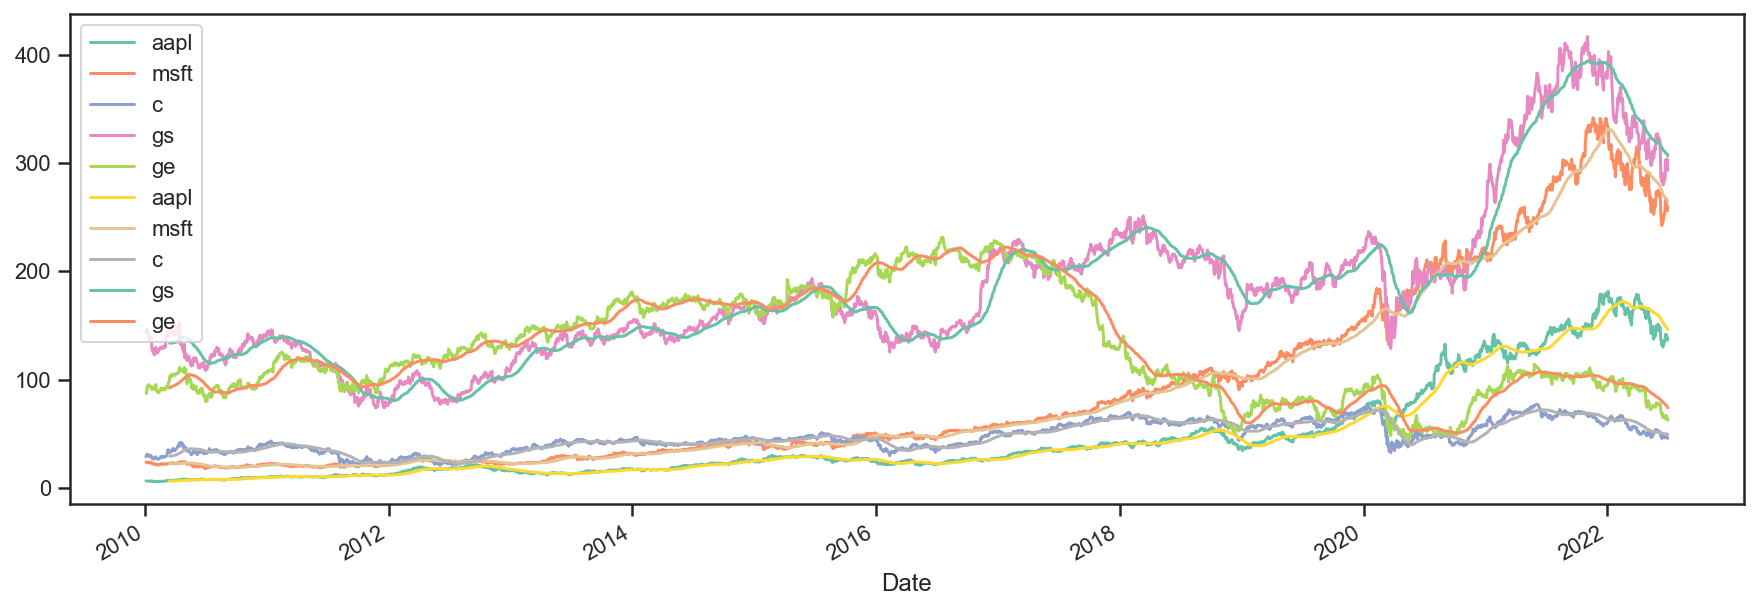

In [27]:
# let's see what the data looks like - this is by no means a pretty chart, but it does the job
plot = bt.merge(data, sma).plot(figsize=(15, 5))


Looks legit.

Now that we have our data, we will need to create our security selection logic. Let's create a basic Algo that will select the securities that are above their moving average.

Before we do that, let's think about how we will code it. We could pass the SMA data and then extract the row (from the sma DataFrame) on the current date, compare the values to the current prices, and then keep a list of those securities where the price is above the SMA. This is the most straightforward approach. However, this is not very re-usable because the logic within the Algo will be quite specific to the task at hand and if we wish to change the logic, we will have to write a new algo. 

For example, what if we wanted to select securities that were below their sma? Or what if we only wanted securities that were 5% above their sma?

What we could do instead is pre-calculate the selection logic DataFrame (a fast, vectorized operation) and write a generic Algo that takes in this boolean DataFrame and returns the securities where the value is True on a given date. This will be must faster and much more reusable. Let's see how the implementation looks like.

In [28]:
class SelectWhere(bt.Algo):
    
    """
    Selects securities based on an indicator DataFrame.
    
    Selects securities where the value is True on the current date (target.now).
    
    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)
    
    Sets:
        * selected
    
    """
    def __init__(self, signal):
        self.signal = signal
        
    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected
        
        # return True because we want to keep on moving down the stack
        return True

In [29]:
# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t)

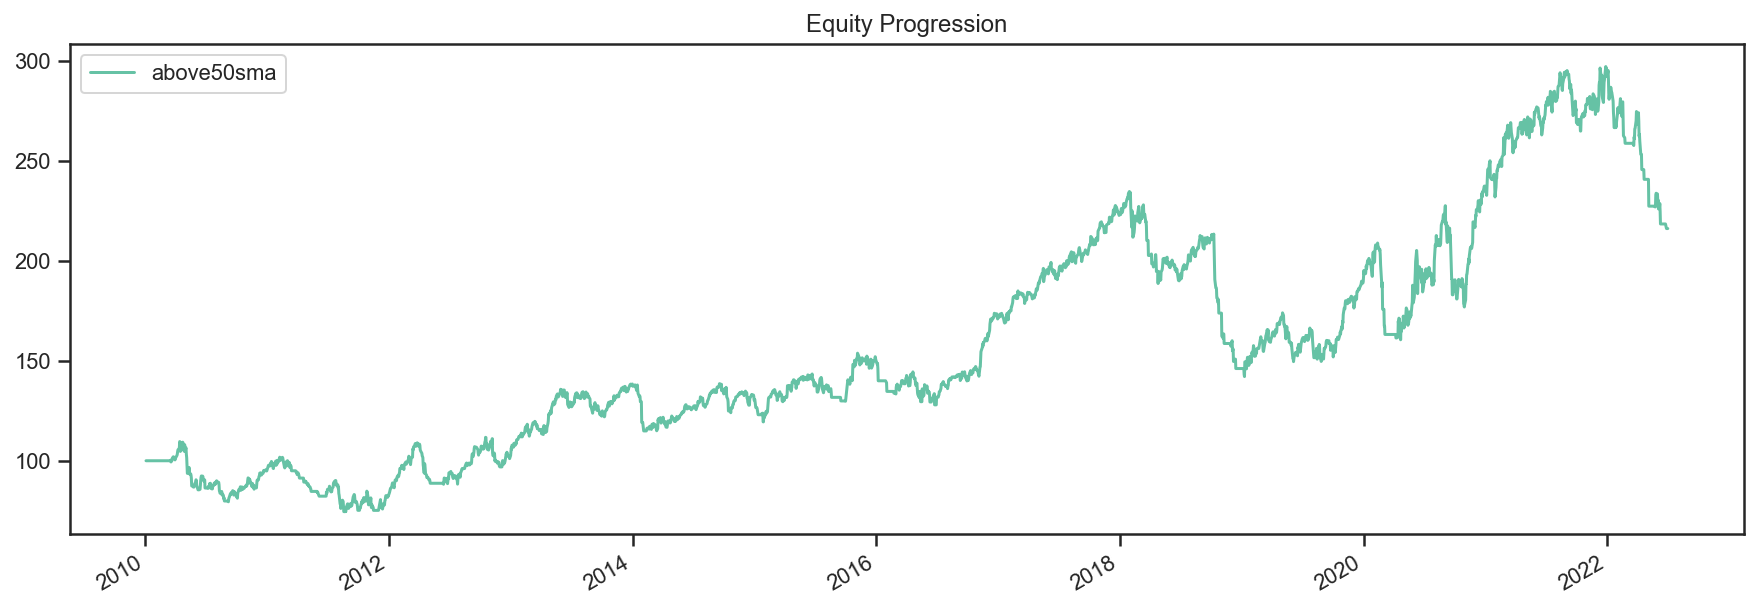

In [30]:
# what does the equity curve look like?
res.plot();

In [31]:
# and some performance stats
res.display()

Stat                 above50sma
-------------------  ------------
Start                2010-01-03
End                  2022-07-01
Risk-free rate       0.00%

Total Return         116.08%
Daily Sharpe         0.42
Daily Sortino        0.63
CAGR                 6.36%
Max Drawdown         -39.43%
Calmar Ratio         0.16

MTD                  0.00%
3m                   -19.50%
6m                   -26.03%
YTD                  -26.03%
1Y                   -22.10%
3Y (ann.)            10.34%
5Y (ann.)            1.89%
10Y (ann.)           8.70%
Since Incep. (ann.)  6.36%

Daily Sharpe         0.42
Daily Sortino        0.63
Daily Mean (ann.)    8.07%
Daily Vol (ann.)     19.45%
Daily Skew           -0.65
Daily Kurt           4.74
Best Day             5.78%
Worst Day            -8.26%

Monthly Sharpe       0.39
Monthly Sortino      0.65
Monthly Mean (ann.)  8.59%
Monthly Vol (ann.)   21.86%
Monthly Skew         -0.37
Monthly Kurt         0.73
Best Month           21.65%
Worst Month          


Nothing stellar but at least you learnt something along the way (I hope). 

Oh, and one more thing. If you were to write your own "library" of backtests, you might want to write yourself a helper function that would allow you to test different parameters and securities. That function might look something like this:

In [32]:
def above_sma(tickers, sma_per=50, start='2010-01-01', name='above_sma'):
    """
    Long securities that are above their n period 
    Simple Moving Averages with equal weights.
    """
    # download data
    data = bt.get(tickers, start=start)
    # calc sma
    sma = data.rolling(sma_per).mean()

    # create strategy
    s = bt.Strategy(name, [SelectWhere(data > sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])    

    # now we create the backtest
    return bt.Backtest(s, data)


This function allows us to easily generate backtests. We could easily compare a few different SMA periods. Also, let's see if we can beat a long-only allocation to the SPY.

In [33]:
# simple backtest to test long-only allocation
def long_only_ew(tickers, start='2010-01-01', name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    data = bt.get(tickers, start=start)
    return bt.Backtest(s, data)

# create the backtests
tickers = 'aapl,msft,c,gs,ge'
sma10 = above_sma(tickers, sma_per=10, name='sma10')
sma20 = above_sma(tickers, sma_per=20, name='sma20')
sma40 = above_sma(tickers, sma_per=40, name='sma40')
benchmark = long_only_ew('spy', name='spy')

# run all the backtests!
res2 = bt.run(sma10, sma20, sma40, benchmark)

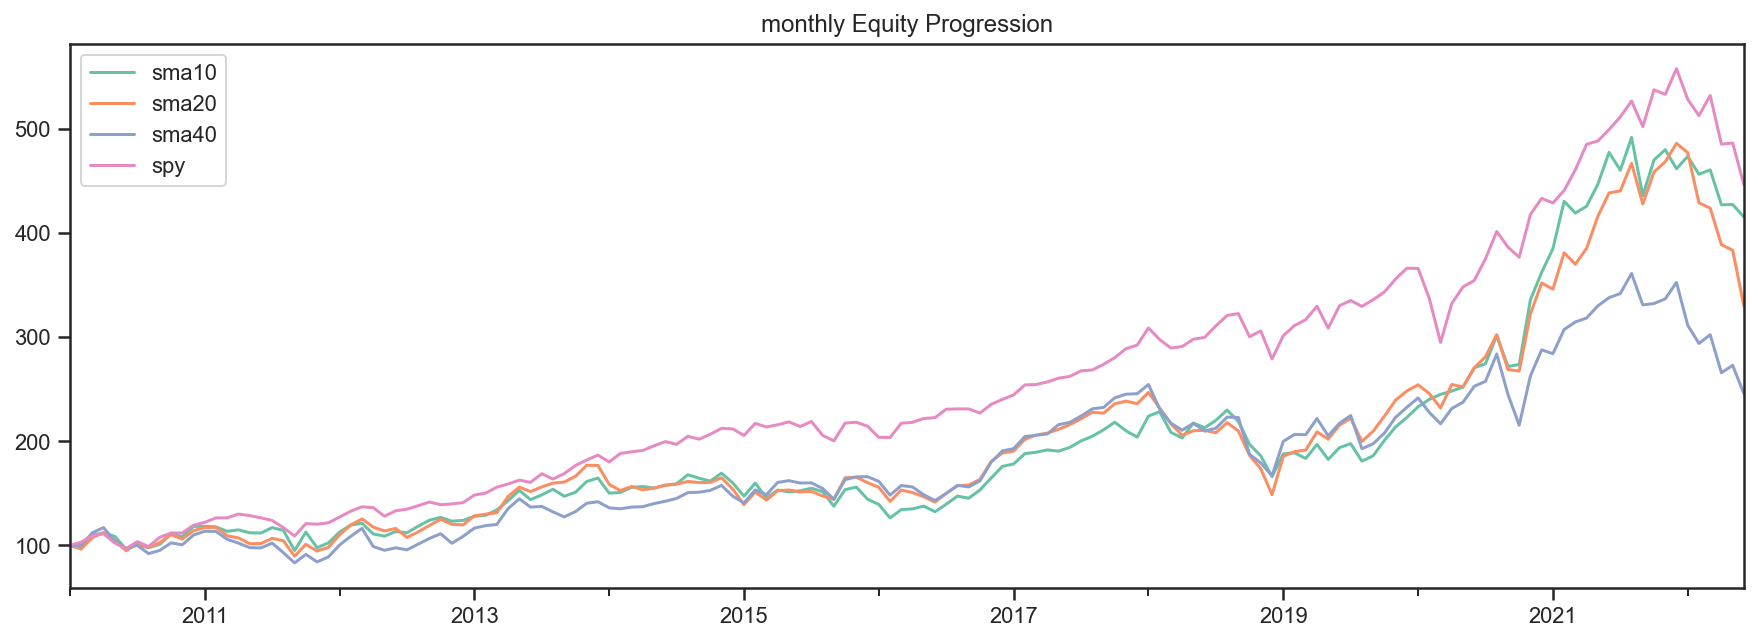

In [34]:
res2.plot(freq='m');

In [35]:
res2.display()

Stat                 sma10       sma20       sma40       spy
-------------------  ----------  ----------  ----------  ----------
Start                2010-01-03  2010-01-03  2010-01-03  2010-01-03
End                  2022-07-01  2022-07-01  2022-07-01  2022-07-01
Risk-free rate       0.00%       0.00%       0.00%       0.00%

Total Return         284.16%     229.80%     145.62%     321.22%
Daily Sharpe         0.63        0.58        0.47        0.75
Daily Sortino        0.99        0.91        0.73        1.15
CAGR                 11.38%      10.03%      7.46%       12.20%
Max Drawdown         -31.77%     -40.72%     -34.93%     -33.72%
Calmar Ratio         0.36        0.25        0.21        0.36

MTD                  -0.76%      0.00%       0.00%       -0.37%
3m                   -10.58%     -22.25%     -18.82%     -16.66%
6m                   -10.71%     -32.14%     -30.31%     -20.28%
YTD                  -10.71%     -32.14%     -30.31%     -20.28%
1Y                   -13.63%   


And there you have it. Beating the market ain't that easy!


## SMA Crossover Strategy

Let's build on the last section to test a moving average crossover strategy. The easiest way to achieve this is to build an Algo similar to SelectWhere, but for the purpose of setting target weights. Let's call this algo WeighTarget. This algo will take a DataFrame of target weights that we will pre-calculate. 

Basically, when the 50 day moving average will be above the 200-day moving average, we will be long (+1 target weight). Conversely, when the 50 is below the 200, we will be short (-1 target weight). 

Here's the WeighTarget implementation (this Algo also already exists in the algos module):

In [36]:
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.
    
    Args:
        * target_weights (DataFrame): DataFrame containing the target weights
    
    Sets:
        * weights
    
    """
    
    def __init__(self, target_weights):
        self.tw = target_weights
    
    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]                

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()
        
        # return True because we want to keep on moving down the stack
        return True


So let's start with a simple 50-200 day sma crossover for a single security.

In [37]:
## download some data & calc SMAs
data = bt.get('spy', start='2010-01-01')
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()

## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma200.copy()
# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0
# here we will set the weight to 0 - this is because the sma200 needs 200 data points before
# calculating its first point. Therefore, it will start with a bunch of nulls (NaNs).
tw[sma200.isnull()] = 0.0


Ok so we downloaded our data, calculated the simple moving averages, and then we setup our target weight (tw) DataFrame. Let's take a look at our target weights to see if they make any sense.

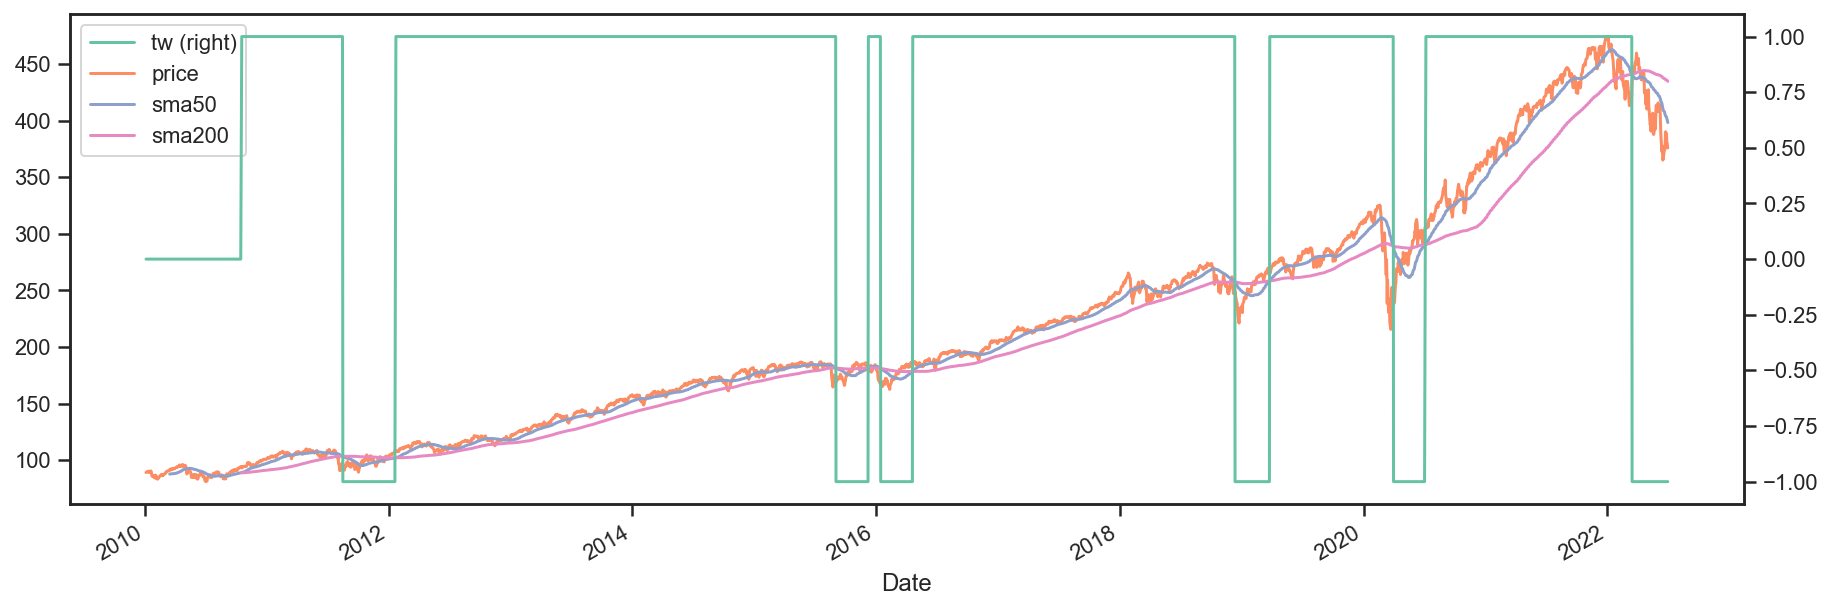

In [38]:
# plot the target weights + chart of price & SMAs
tmp = bt.merge(tw, data, sma50, sma200)
tmp.columns = ['tw', 'price', 'sma50', 'sma200']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])


As mentioned earlier, it's always a good idea to plot your strategy data. It is usually easier to spot logic/programming errors this way, especially when dealing with lots of data. 

Now let's move on with the Strategy & Backtest. 

In [39]:
ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(ma_cross, data)
res = bt.run(t)

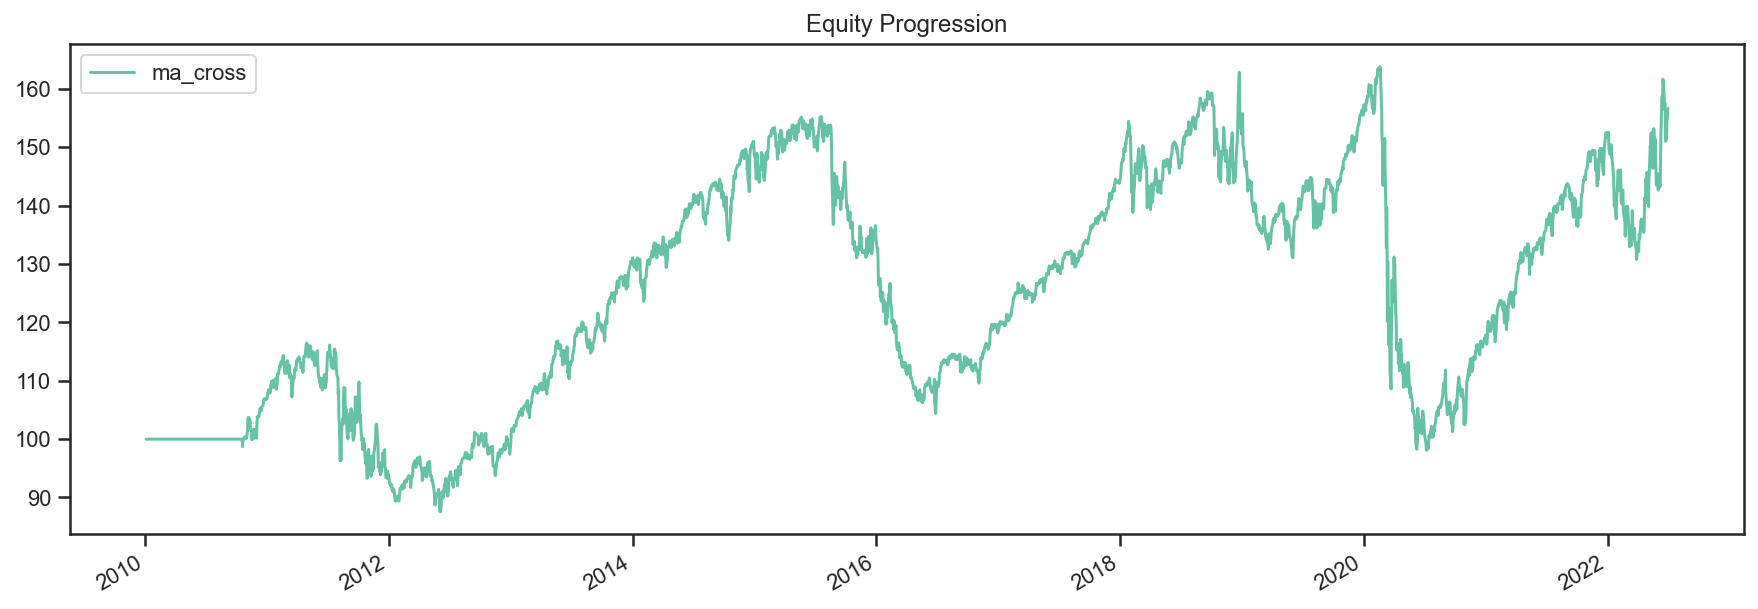

In [40]:
res.plot();


Ok great so there we have our basic moving average crossover strategy. 

## Exploring the Tree Structure

So far, we have explored strategies that allocate capital to securities. But what if we wanted to test a strategy that allocated capital to sub-strategies?

The most straightforward way would be to test the different sub-strategies, extract their equity curves and create "synthetic securities" that would basically just represent the returns achieved from allocating capital to the different sub-strategies.

Let's see how this looks:

In [41]:
# first let's create a helper function to create a ma cross backtest
def ma_cross(ticker, start='2010-01-01', 
             short_ma=50, long_ma=200, name='ma_cross'):
    # these are all the same steps as above
    data = bt.get(ticker, start=start)
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()

    # target weights
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0    
    tw[long_sma.isnull()] = 0.0
    
    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    return bt.Backtest(s, data)

# ok now let's create a few backtests and gather the results.
# these will later become our "synthetic securities"
t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')

# let's run these strategies now
res = bt.run(t1, t2)

# now that we have run the strategies, let's extract
# the data to create "synthetic securities"
data = bt.merge(res['aapl_ma_cross'].prices, res['msft_ma_cross'].prices)

# now we have our new data. This data is basically the equity
# curves of both backtested strategies. Now we can just use this
# to test any old strategy, just like before.
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, data)
res = bt.run(t)

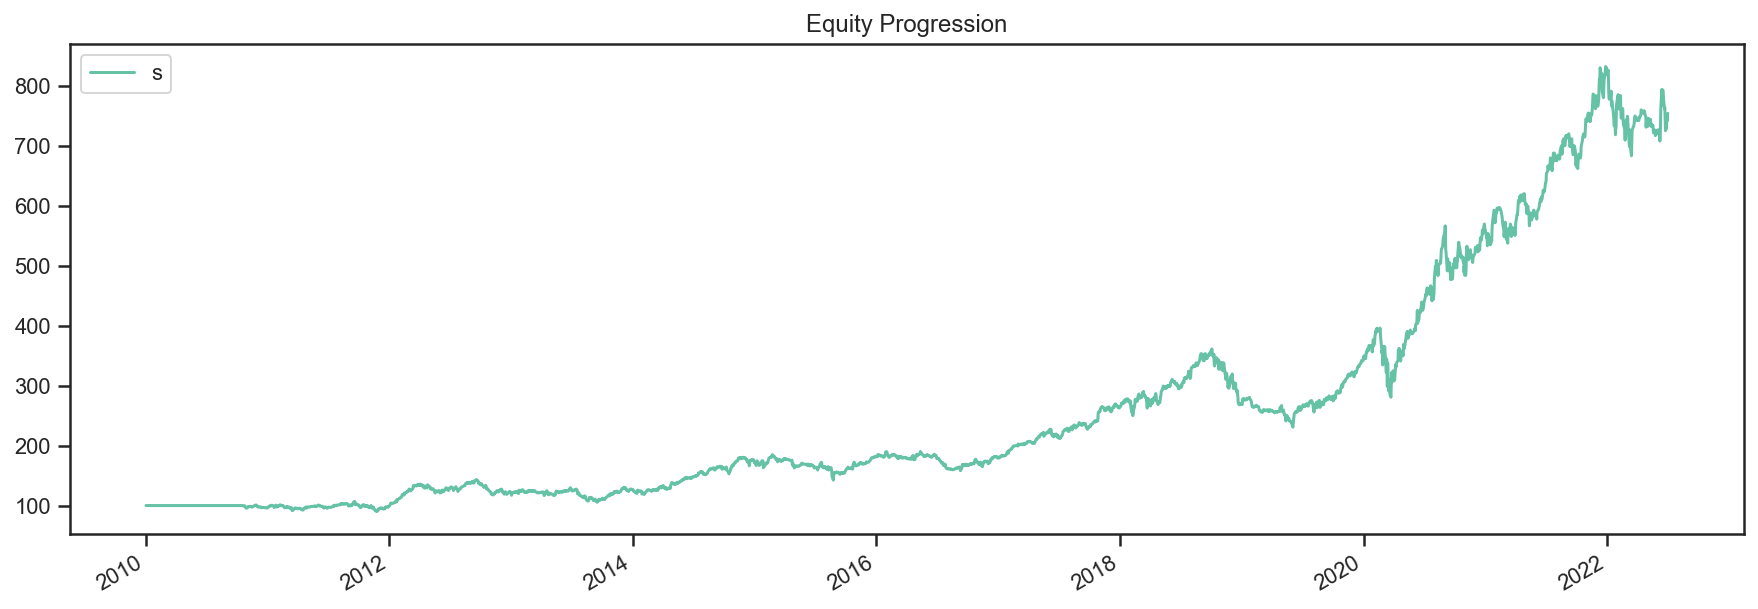

In [42]:
res.plot();

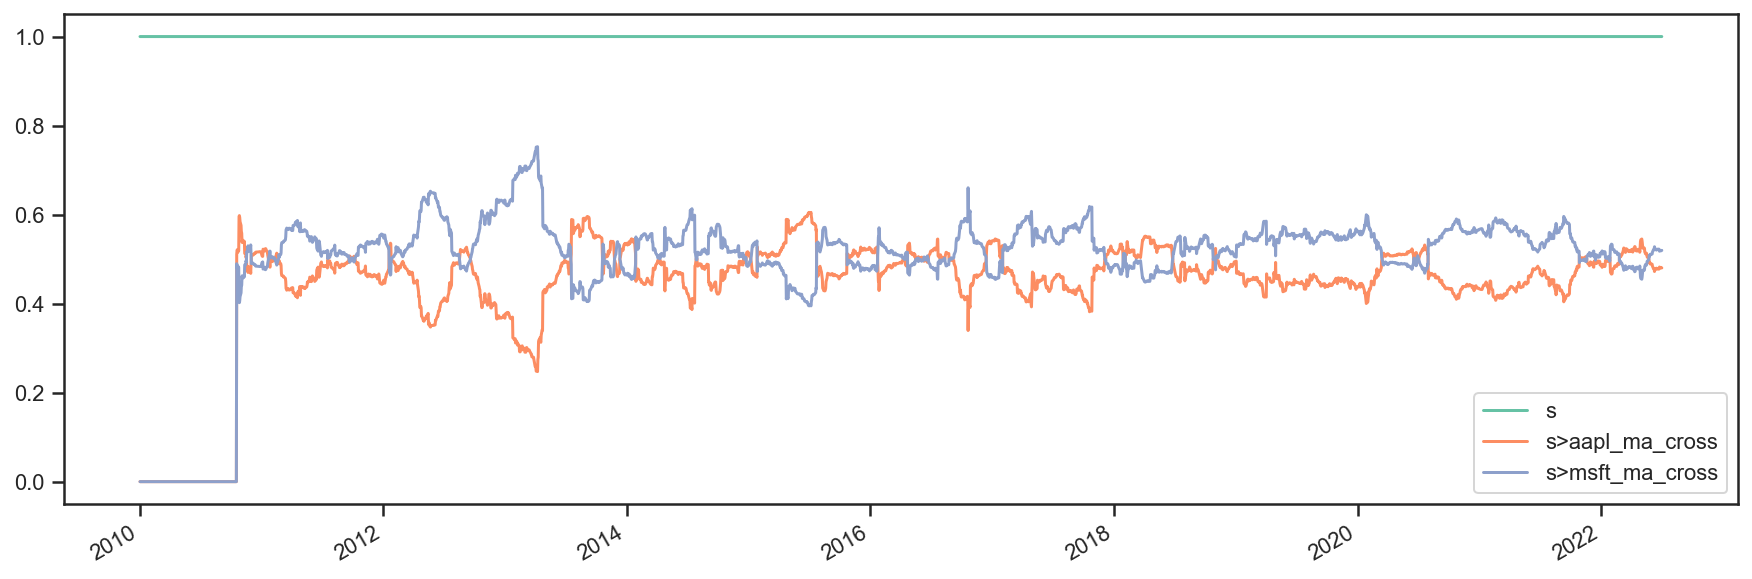

In [43]:
res.plot_weights();


As we can see above, the process is a bit more involved, but it works. It is not very elegant though, and obtaining security-level allocation information is problematic. 

Luckily, bt has built-in functionality for dealing with strategies of strategies. It uses the same general principal as demonstrated above but does it seamlessly. Basically, when a strategy is a child of another strategy, it will create a "paper trade" version of itself internally. As we run our strategy, it will run its internal "paper version" and use the returns from that strategy to populate the **price** property.

This means that the parent strategy can use the price information (which reflects the returns of the strategy had it been employed) to determine the appropriate allocation. Again, this is basically the same process as above, just packed into 1 step.

Perhaps some code will help:

In [44]:
# once again, we will create a few backtests
# these will be the child strategies
t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')

# let's extract the data object
data = bt.merge(t1.data, t2.data)

# now we create the parent strategy
# we specify the children to be the two 
# strategies created above
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()],
                [t1.strategy, t2.strategy])

# create and run
t = bt.Backtest(s, data)
res = bt.run(t)

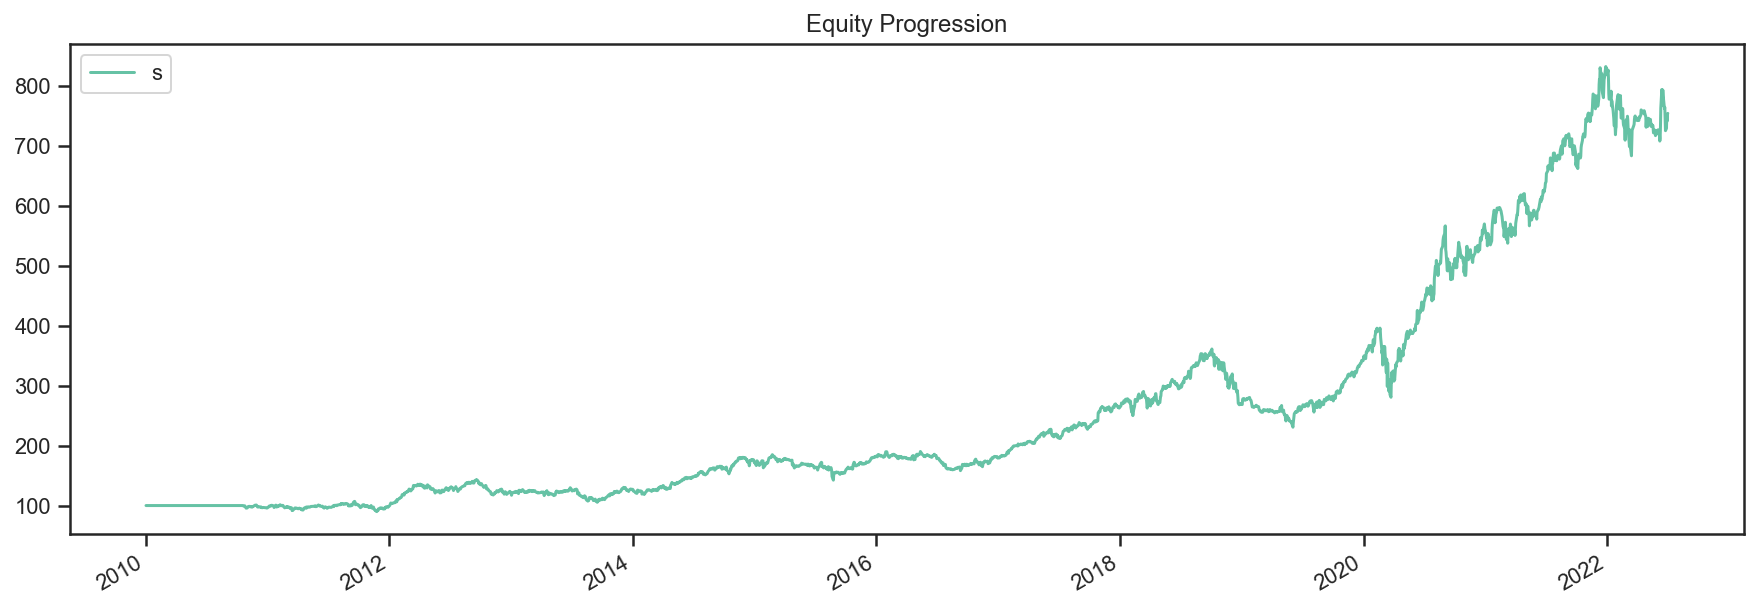

In [45]:
res.plot();

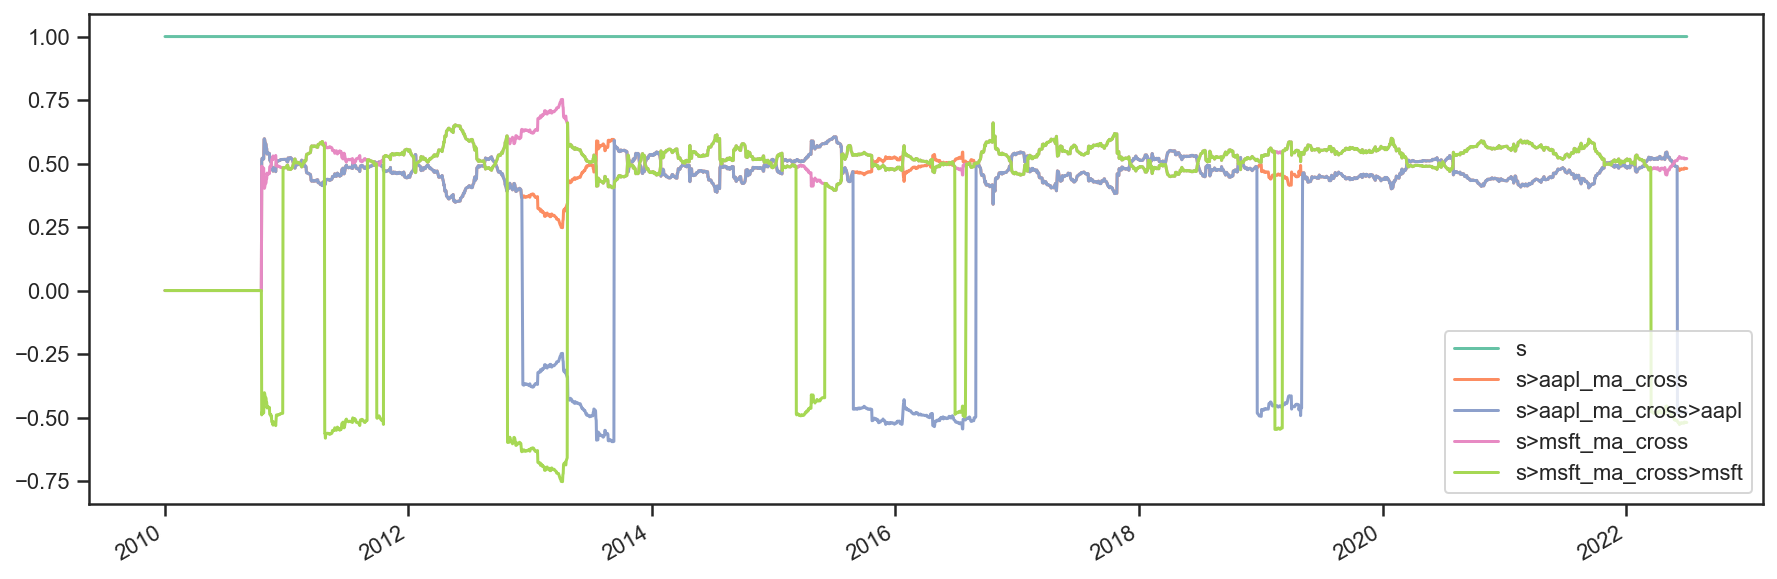

In [46]:
res.plot_weights();


So there you have it. Simpler, and more complete. 